In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from scipy import interpolate
from scipy.signal import hilbert

In [2]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    
    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        lmax = lmax[s[lmax]>s_mid]

    # global min of dmin-chunks of locals min 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global max of dmax-chunks of locals max 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

## Load data

In [40]:
#sin with noize.txt
#x = np.loadtxt("new_outputs/I_noize.txt")
#y = np.loadtxt("new_outputs/output_noize.txt")

#smooth sin.txt
x = np.loadtxt("new_outputs/I_sin.txt")
y = np.loadtxt("new_outputs/output_sin.txt")

#gauss.txt
#x = np.loadtxt("new_outputs/I_gauss.txt")
#y = np.loadtxt("new_outputs/output_gauss.txt")

#3days.txt
#x = np.loadtxt("new_outputs/I_3days.txt")
#y = np.loadtxt("new_outputs/output_3days.txt")

print(x.shape)
print(y.shape)

(2000, 200)
(40000, 64)


In [41]:
#non 3days.txt
y = y.reshape(2000,20,64)
#3days.txt
#y = y.reshape(6500,20,64)

In [42]:
data_boyarsk = pd.read_excel('data/boyarsk2021.xlsx')
data_machta = pd.read_excel('data/machta2020.xlsx')
data_ozone = pd.read_csv('data/ozone.csv', header=None)
nums = np.linspace(195, 555, 4344)
data_ozone['ind'] = nums

In [43]:
#gauss.txt
ticks_gauss = [
    "0:01:04", "0:38:03","1:15:03","1:52:01",
    "2:28:59","3:06:58","3:42:56","4:19:55",
    "4:56:54","5:33:52","6:10:51","6:47:50",
    "7:24:48","8:01:46","8:38:45","9:15:43",
    "9:52:42","10:29:40","11:06:39","11:43:37",
    "12:20:36","12:57:35","13:34:34","14:11:33",
    "14:48:33","15:25:33","16:02:32","16:39:32",
    "17:16:32","17:53:30","18:30:29","19:07:31",
    "19:44:30","20:21:29","20:58:28","21:35:28",
    "22:12:28","22:49:27","23:26:27"]

pos_gauss = np.linspace(0,584,len(ticks_gauss))
pos_gauss = pos_gauss[3:-4]
ticks_gauss = ticks_gauss[3:-4]

#sin.txt
label = data_boyarsk[data_boyarsk.columns[2]][76:781]
sin_labels = label[285:440]
ticks_sin = [str(item)[11:-3] for item in sin_labels]
pos_sin = np.linspace(15,584,155)

#3days.txt
three_days_labels = label[:440]
ticks_3days = [str(item)[5:-3] for item in three_days_labels]
pos_3days = np.linspace(0.8,580,440)+6

## Field measurements, 5 days

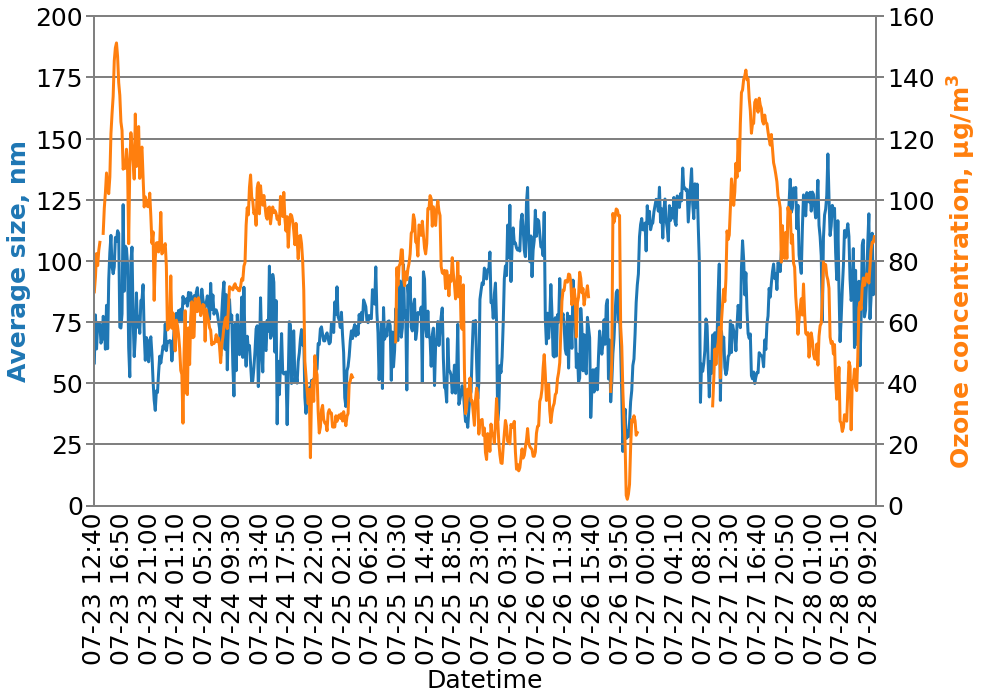

In [44]:
fig, ax1 = plt.subplots(figsize=(14,9))

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

ax2 = ax1.twinx()


plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

ax1.set_ylabel("Average size, nm", fontsize=25, color='C0', fontweight='bold')
ax2.set_ylabel("Ozone concentration, ${\mathbf{\mu g/m^3}}$", fontsize=25, color='C1', fontweight='bold')
ax2.yaxis.set_label_coords(1.09, 0.48)

ax2.grid(axis='y', lw=2, color='grey')


label_pos = np.arange(76, 781)
label = [str(item)[5:-3] for item in data_boyarsk[data_boyarsk.columns[2]][label_pos]]

ax2.plot(label_pos, data_boyarsk['O3 (2 м)'][76:781], color='C1', lw=3)
ax1.plot(label_pos, data_boyarsk['Dm'][76:781]*900000000, lw=3)
ax2.set_ylim([0,160])
ax1.set_ylim([0, 200])

ax1.tick_params(bottom = False)

ax1.tick_params('both', length=8, which='major', color='grey', width='2')
ax2.tick_params('both', length=8, which='major', color='grey', width='2')

for spine in ax2.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(2)

ax1.set_xticks(ticks=label_pos[::25], labels=label[::25], va='center')
ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=75)
plt.xlim([76, 781])
ax1.set_xlabel("Datetime", fontsize=25)
plt.savefig("data.pdf", bbox_inches='tight', format='pdf')

## Data model mapping

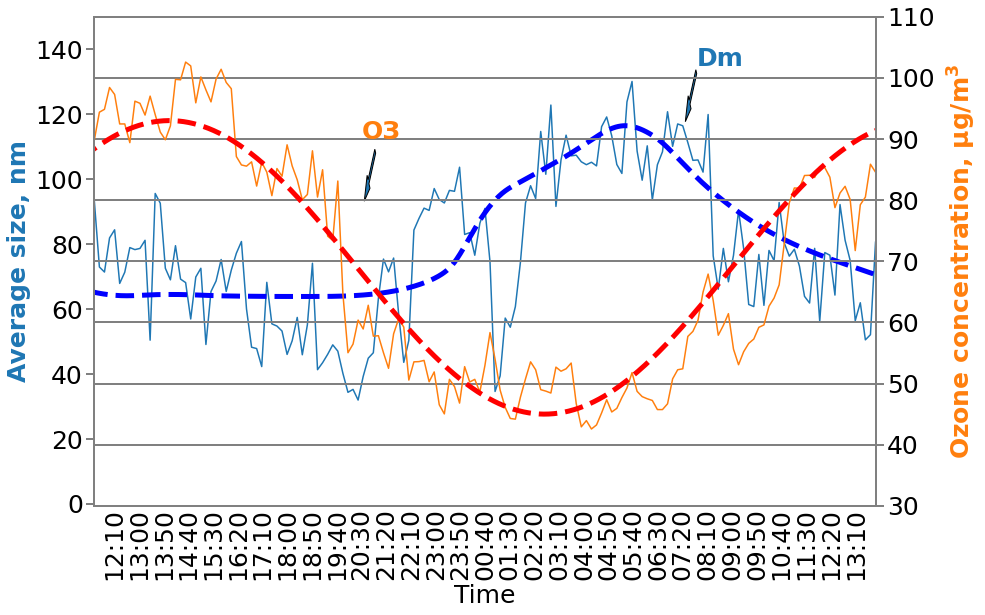

In [45]:
dm = np.array(data_boyarsk['Dm'])
dm_clip = dm[76:781]
o3 = np.array(data_boyarsk['O3 (2 м)'])#.fillna(0))
o3_clip = o3[76:781]

val = 14

#3days.txt
#fig, ax1 = plt.subplots(figsize=(21,9))

#non 3days.txt
fig, ax1 = plt.subplots(figsize=(14,9))


plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

#non 3days.txt
st = 1000
#3days.txt
#st = 500

sizes = (y[st:, val,:])*np.linspace(1,64,64)

ax2 = ax1.twinx()

#3days.txt
#ax1.plot(np.linspace(0, 584, 440), dm_clip[:440]*800000000-20)
#ax2.plot(np.linspace(0, 584, 440), o3_clip[:440]/1.5+35, 'C1')
#ax1.plot(np.linspace(0,584,6000), (sizes.mean(axis=1)/y[st:, val,:].mean(axis=1))*10-70, 'b--', lw=5)
#ax2.plot(np.linspace(0,584,6000), x[500:,val*10]*1400+33, 'r--', lw=5)

#gauss.txt
#ax1.plot(np.arange(0, 584), data_machta['Dm']*900000000)
#ax2.plot(data_ozone['ind'][::5][:-100], data_ozone[1][::5][:-100]/1.5+25, 'C1')
#ax1.plot(np.linspace(-100,515,1000), (sizes.mean(axis=1)/y[st:, val,:].mean(axis=1))*45-420, 'b--', lw=5)
#ax2.plot(np.linspace(38,515,1000), x[st:,val*10]*2360-10, 'r--', lw=5)

#sin.txt
ax1.plot(np.linspace(0, 584, 155), dm_clip[285:440]*900000000)
ax2.plot(np.linspace(0, 584, 155), o3_clip[285:440]/1.5+35, 'C1')
#sin with noize.txt
#ax1.plot(np.linspace(0,584,1000), (sizes.mean(axis=1)/y[st:, val,:].mean(axis=1))*22-180, 'b--', lw=5)
#ax2.plot(np.linspace(0,584,1000), x[:,val*10][1000:]*1400+31, 'r--', lw=5)
#smooth sin.txt
ax1.plot(np.linspace(-40,584,1000), (sizes.mean(axis=1)/y[1000:, val,:].mean(axis=1))*11-50, 'b--', lw=5)
ax2.plot(np.linspace(-40,584,1000), x[:,val*10][1000:]*600+45, 'r--', lw=5)

ax1.set_ylabel("Average size, nm", fontsize=25, color='C0', fontweight='bold')
ax2.set_ylabel("Ozone concentration, ${\mathbf{\mu g/m^3}}$", fontsize=25, color='C1', fontweight='bold')
ax2.yaxis.set_label_coords(1.09, 0.5)
ax2.grid(axis='y', lw=2, color='grey')
plt.yticks(fontsize=25)

#gauss.txt
#ax1.set_ylim([-0.6,200])
#ax2.set_ylim([20,160])
#sin.txt
ax1.set_ylim([-0.6,150])
ax2.set_ylim([30,110])
#3days.txt
#ax1.set_ylim([-0.6,100])
#ax2.set_ylim([20,160])

#gauss.txt
#ax1.set_xlim([40,515])
#ax2.set_xlim([40,515])
#sin.txt and 3days.txt
ax1.set_xlim([0,584])
ax2.set_xlim([0,584])


ax1.tick_params(bottom = False)

ax1.tick_params('both', length=8, which='major', color='grey', width='2')
ax2.tick_params('both', length=8, which='major', color='grey', width='2')

for spine in ax2.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(2)

#gauss.txt
#plt.arrow(240,126,5,-5,width=0.9, head_width=3)
#plt.text(220,130, "ОЗ", color='C1', fontsize=25, fontweight='bold')
#plt.arrow(480,116,-5,-5,width=0.9, head_width=3)
#plt.text(480,120, "Dm", color='C0', fontsize=25, fontweight='bold')
#sin.txt
plt.arrow(210,88,-5,-5,width=0.9, head_width=3)
plt.text(200,90, "ОЗ", color='C1', fontsize=25, fontweight='bold')
plt.arrow(450,101,-5,-5,width=0.9, head_width=3)
plt.text(450,102, "Dm", color='C0', fontsize=25, fontweight='bold')

#gauss.txt
#ax1.set_xticks(ticks=pos_gauss[::2], labels=ticks_gauss[::2], va='center')
#ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=50)
#sin.txt
ax1.set_xticks(ticks=pos_sin[::5], labels=ticks_sin[::5], va='center')
ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=30)
#3days.txt
#ax1.set_xticks(ticks=pos_3days[::16], labels=ticks_3days[::16], va='center')
#ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=70)

#non 3days.txt
ax1.set_xlabel("Time", fontsize=25)
#3days.txt
#ax1.set_xlabel("Datetime", fontsize=25)

#sin with noize.txt
#plt.savefig("map_noize.pdf", bbox_inches='tight', format='pdf')
#smooth sin.txt
plt.savefig("map_sin.pdf", bbox_inches='tight', format='pdf')
#gauss.txt
#plt.savefig("gauss.pdf", bbox_inches='tight', format='pdf')
#3days.txt
#plt.savefig("3days.pdf", bbox_inches='tight', format='pdf')

## Resampling field data for model input

In [30]:
#import numpy as np
#import matplotlib.pyplot as plt
#import resampy
#a = np.loadtxt("data/1.txt")
#plt.plot(a)
#print(a.shape)
#interp_arr = resampy.resample(a, a.shape[0]*5, 6060*5)
#res = np.concatenate((np.ones(500)*interp_arr[30], interp_arr[30:-30]))
#plt.figure()
#plt.plot(res/80)
#print(res.shape)
#np.savetxt("data/1_resampled.txt", res/80)
#print(res.max())
#print(res.min())

In [193]:
#import resampy
#a = np.loadtxt("data/2.txt")
#plt.plot(a)
#print(a.shape)
#interp_arr = resampy.resample(a, a.shape[0]*5, 1020*5)
#plt.figure()
#plt.plot(interp_arr[10:-10])
#print(interp_arr.shape)
#np.savetxt("data/2_resampled.txt", interp_arr[10:-10]/80)
#interp_arr[10:-10].max()/8.67388
#print(interp_arr[10:-10].max())
#print(interp_arr[10:-10].min())

## Model predictions at different lengths

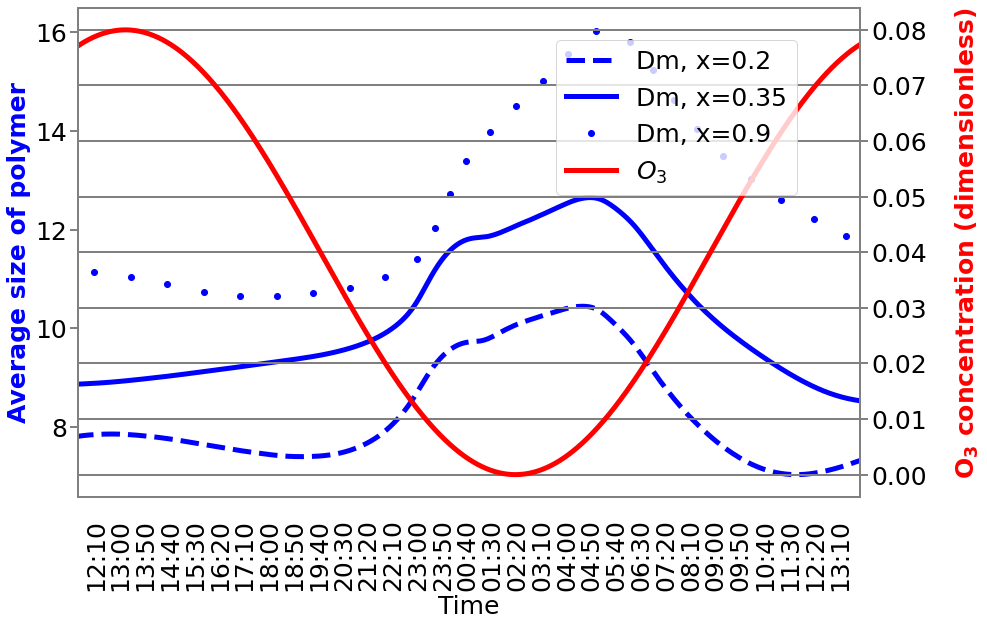

In [50]:
ticks_pos = np.linspace(0.12,1,len(ticks_sin))
ticks = ticks_sin


fig, ax1 = plt.subplots(figsize=(14,9))


plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

val = 7
sizes = y[st:,val,:]*np.linspace(1,64,64)

val_sm = 4
sizes_sm = y[st:, val_sm,:]*np.linspace(1,64,64)

val_bg = 18
sizes_bg = y[st:, val_bg,:]*np.linspace(1,64,64)

ax2 = ax1.twinx()


ax1.plot(np.linspace(0,1,1000), sizes_sm.mean(axis=1)/y[st:, val_sm,:].mean(axis=1), 'b--', label="Dm, x="+str(round(val_sm/20.,2)), lw=5)

ax1.plot(np.linspace(0,1,1000), sizes.mean(axis=1)/y[st:, val,:].mean(axis=1), 'b', label="Dm, x="+str(round(val/20.,2)), lw=5)

ax1.plot(np.linspace(0,1,1000), sizes_bg.mean(axis=1)/y[st:, val_bg,:].mean(axis=1), 'bo', label="Dm, x="+str(round(val_bg/20.,2)), lw=5, markevery=0.04)

ax2.plot(np.linspace(0,1,1000), x[st:,val*10], 'r', label="$O_3$", lw=5)

ax1.set_ylabel("Average size of polymer", fontsize=25, color='blue', fontweight='bold')
ax2.set_ylabel("$\mathbf{O_3}$ concentration (dimensionless)", fontsize=25, color='red', fontweight='bold')

ax2.yaxis.set_label_coords(1.12, 0.52)

ax2.grid(axis='y', lw=2, color='grey')

plt.yticks(fontsize=25)

ax1.tick_params(bottom = False)

ax1.tick_params('both', length=8, which='major', color='grey', width='2')
ax2.tick_params('both', length=8, which='major', color='grey', width='2')

for spine in ax2.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(2)

    
ax1.set_xticks(ticks=ticks_pos[::5], labels=ticks[::5], va='center')
ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=50)


ax1.set_xlim([0.1,1])
ax2.set_xlim([0.1,1])
ax1.set_xlabel("Time", fontsize=25)

fig.legend(fontsize=25, bbox_to_anchor=(0.35, 0.35, 0.5, 0.5))
plt.yticks(fontsize=25)
plt.savefig("num_ozon.pdf", bbox_inches='tight', format='pdf')


## Particle size distributions

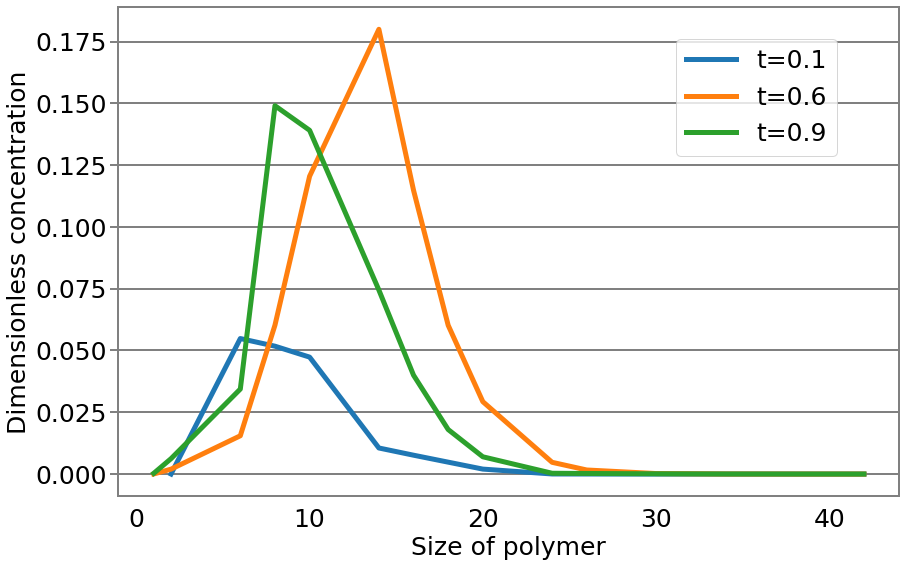

In [51]:
fig, ax1 = plt.subplots(figsize=(14,9))

vs = [0,0,0]

vs[0] = 1100
vs[1] = 1600
vs[2] = 1900

vv2=14

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)


ss = np.arange(64)

_, max_sm = hl_envelopes_idx(y[vs[0], vv2, :])
max_sm = np.insert(max_sm, 0 , 2)

ax1.plot(ss[max_sm], y[vs[0], vv2, max_sm]*1e4, color='C0', label="t="+str(round((vs[0]-st)*0.001,2)), lw=5)

_, max_av = hl_envelopes_idx(y[vs[1], vv2, :])
max_av = np.insert(max_sm, 0 , 1)

ax1.plot(ss[max_av], y[vs[1], vv2, max_av]*1e4, color='C1', label="t="+str(round((vs[1]-st)*0.001,2)), lw=5)

_, max_bg = hl_envelopes_idx(y[vs[2], vv2, :])
max_bg = np.insert(max_sm, 0 , 1)

ax1.plot(ss[max_bg], y[vs[2], vv2, max_bg]*1e4, color='C2',label="t="+str(round((vs[2]-st)*0.001,2)), lw=5)

ax1.set_ylabel("Dimensionless concentration", fontsize=25)
ax1.set_xlabel("Size of polymer", fontsize=25)


#ax1.yaxis.set_label_coords(1.07, 0.57)

ax1.grid(axis='y', lw=2, color='grey')

ax1.tick_params(bottom = False)

ax1.tick_params('both', length=8, which='major', color='grey', width='2')

for spine in ax1.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(2)

#ax1.set_ylim([-0.00,0.0004])

#plt.xlim(0,40)
fig.legend(fontsize=25, bbox_to_anchor=(0.35, 0.35, 0.5, 0.5))
plt.savefig("num_spectra.pdf", bbox_inches='tight', format='pdf')




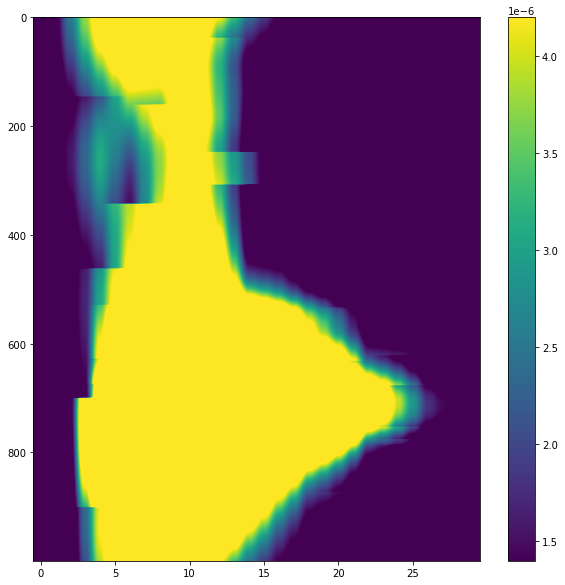

In [52]:
val = 12
sizes = y[1000:,val, :]

sizes_new = np.zeros(sizes.shape)

for i in range(sizes.shape[0]):
    vale = sizes[i, :]
    x = np.arange(64)
    lmin, lmax = hl_envelopes_idx(vale)
    lmax = np.insert(lmax, 0, 0)
    lmax = np.insert(lmax, len(lmax),len(x)-1)
    x_new = x[lmax]
    y_new = vale[lmax]
    f = interpolate.interp1d(x_new, y_new)
    y_old = f(x)
    sizes_new[i, :] = y_old.copy()




plt.figure(figsize=(10,10))
plt.imshow(sizes_new[:,:30], aspect='auto',
           vmin=0.0000014, vmax=0.0000042)
plt.colorbar()

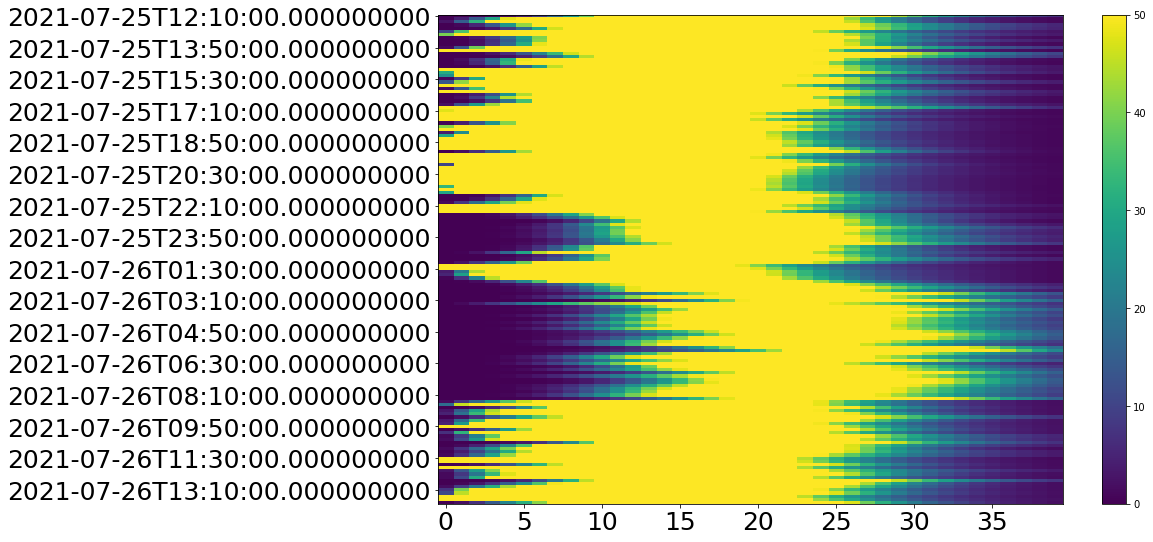

In [87]:
sp_ticks=['0~5', '5~10', '10~15', '15~20', '20~25', '25~30', '30~35', '35~40',
       '40~45', '45~50', '50~55', '55~60', '60~65', '65~70', '70~75', '75~80',
       '80~85', '85~90', '90~95', '95~100', '100~105', '105~110', '110~115',
       '115~120', '120~125', '125~130', '130~135', '135~140', '140~145',
       '145~150', '150~155', '155~160', '160~165', '165~170', '170~175',
       '175~180', '180~185', '185~190', '190~195', '195~200']

sp_ticks_pos = np.arange(len(sp_ticks))

dd = data_boyarsk[sp_ticks][76:781]
dt = data_boyarsk['Unnamed: 2'][76:781]
dd = (dd[dd.columns][285:440]).values
dt = dt[285:440].values

fig, ax1 = plt.subplots(figsize=(14,9))

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(np.arange(len(dt))[::10], dt[::10])

plt.imshow(dd.astype(float), aspect='auto', vmax=50)
plt.colorbar()

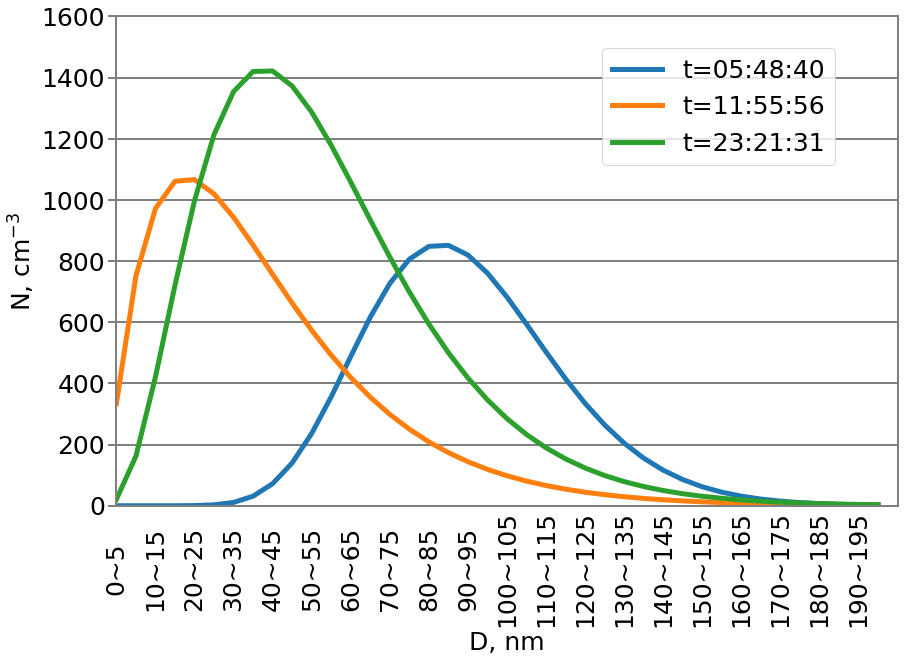

In [88]:
dp = data_machta[sp_ticks].values

fig, ax1 = plt.subplots(figsize=(14,9))

plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

vs = [141, 290, 568]

ax1.plot(dp[vs[0]], color='C0', label="t="+str(data_machta['Time'][vs[0]]), lw=5)
ax1.plot(dp[vs[1]], color='C1', label="t="+str(data_machta['Time'][vs[1]]), lw=5)
ax1.plot(dp[vs[2]], color='C2',label="t="+str(data_machta['Time'][vs[2]]), lw=5)

#ax1.set_xlabel("время (безразмерное)", fontsize=20)
ax1.set_ylabel("N, cm$^{-3}$", fontsize=25,color='black')
ax1.set_xlabel("D, nm", fontsize=25, color='black')

ax1.grid(axis='y', lw=2, color='grey')

ax1.tick_params(bottom = False)

ax1.tick_params('both', length=8, which='major', color='grey', width='2')

for spine in ax1.spines.values():
    spine.set_edgecolor('grey')
    spine.set_linewidth(2)

#ax1.set_xlim([0,1])
ax1.set_ylim([0.0,1600])

ax1.set_xticks(ticks=sp_ticks_pos[::2], labels=sp_ticks[::2], va='center')
ax1.xaxis.set_tick_params(rotation=90, labelsize=25, pad=55)

plt.xlim(0,40)
fig.legend(fontsize=25, bbox_to_anchor=(0.35, 0.35, 0.5, 0.5))
plt.savefig("spectra.pdf", bbox_inches='tight', format='pdf')